In [33]:
# Imports
from sklearn.tree import DecisionTreeClassifier
from lib.utils import load_raw,load_psd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot
from tqdm import tqdm

In [34]:
raw = load_raw(2)
df = load_psd(2)

In [35]:
eeg = raw.get_data(picks='EEG')[0]

In [36]:
X = eeg.reshape(-1,5000)
y = np.array(pd.Categorical(df['label']).codes)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).reshape(-1,1).long()

In [37]:
s_idx = np.where(y==1)[0]
w_idx = np.where(y==2)[0]
idx = np.concatenate([s_idx,w_idx])
X = X[idx]
y = y[idx]-1

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.5,shuffle=True,stratify=y)

In [39]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = nn.Linear(5000,10000)
        self.r1 = nn.ReLU()
        self.d2 = nn.Linear(10000,5000)
        self.r2 = nn.ReLU()
        self.d3 = nn.Linear(5000,2)

    def forward(self,x):
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        x = self.r2(x)
        x = self.d3(x)
        return x
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [40]:
model(X_train[0].cuda()).shape

torch.Size([2])

In [41]:
y_train_one_hot = one_hot(y_train,num_classes=2).reshape(-1,2).float()
y_test_one_hot = one_hot(y_test,num_classes=2).reshape(-1,2).float()

In [42]:
train_losses= []
test_losses = []

In [43]:
from torch.utils.data import TensorDataset
training_data = TensorDataset(X_train,y_train_one_hot)
testing_data = TensorDataset(X_test,y_test_one_hot)
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=256, shuffle=True)

In [44]:
device = 'cuda'

In [ ]:
X,y = next(iter(train_dataloader))
X,y = X.to(device), y.to(device)
for epoch in range(1000):
    training_loss = 0
    logits = model(X)
    loss = criterion(logits,y)
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

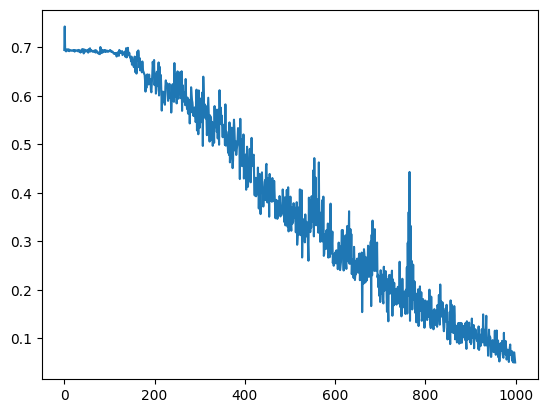

In [46]:
plt.plot(train_losses)

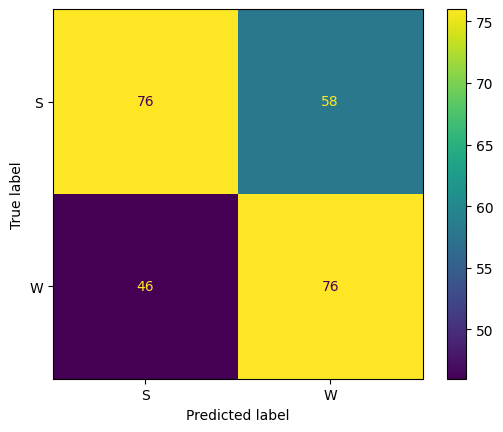

In [100]:
X,y = next(iter(test_dataloader))
X,y = X.to(device), y.to(device)
y_pred_logits = model(X.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1).cpu()
y = y.argmax(axis=1).cpu()
cm = ConfusionMatrixDisplay(confusion_matrix(y,y_pred),display_labels=['S','W'])
cm.plot()

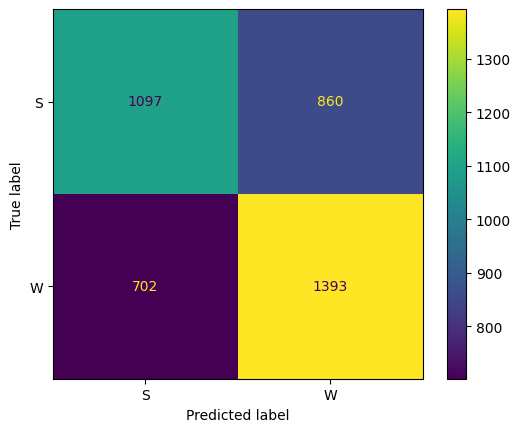

In [76]:
y_pred_logits = model(X_test.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test.squeeze(),y_pred.cpu()),display_labels=['S','W'])
cm.plot()

In [102]:
plt.plot(model.c1.weight.T.squeeze().cpu().detach())

AttributeError: 'MLP' object has no attribute 'c1'

: 